# Alzheimers Diagnosis

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

In [ ]:
df=pd.read_csv("/data/df_mock_latest2.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31437 entries, 0 to 31436
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NACCID              31437 non-null  object 
 1   NACCAGE_1           31437 non-null  int64  
 2   STROKE_1            31437 non-null  int64  
 3   TOBAC30_1           31437 non-null  int64  
 4   NACCFAM_1           31437 non-null  int64  
 5   SEX_1               31437 non-null  int64  
 6   EDUC_1              31437 non-null  int64  
 7   HYPERTEN_BIN_1      31437 non-null  int64  
 8   DIABETES_BIN_1      31437 non-null  int64  
 9   HYPERCHO_BIN_1      31437 non-null  int64  
 10  CVHATT_BIN_1        31437 non-null  int64  
 11  ALCOHOL_BIN_1       31437 non-null  int64  
 12  NACCBMI_1           31437 non-null  float64
 13  BPSYS_1             31437 non-null  int64  
 14  COGMODE_1           31437 non-null  int64  
 15  DEPD_1              31437 non-null  int64  
 16  MEMO

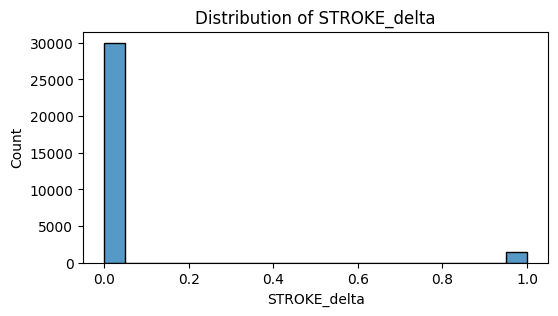

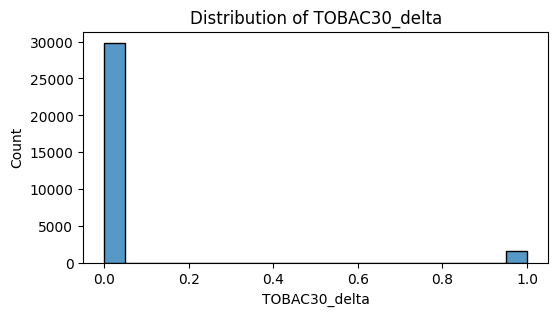

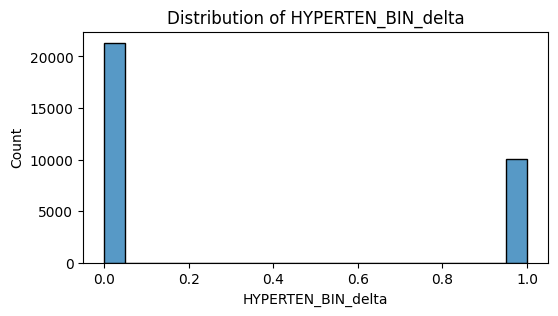

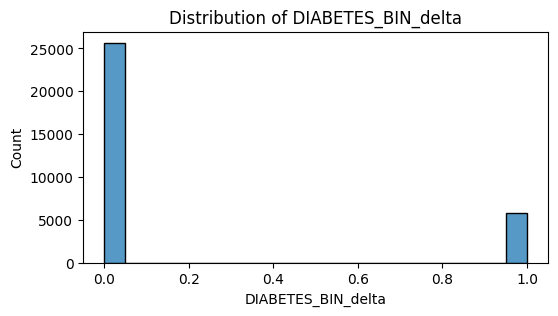

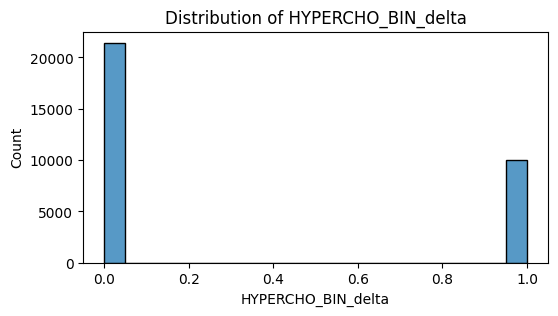

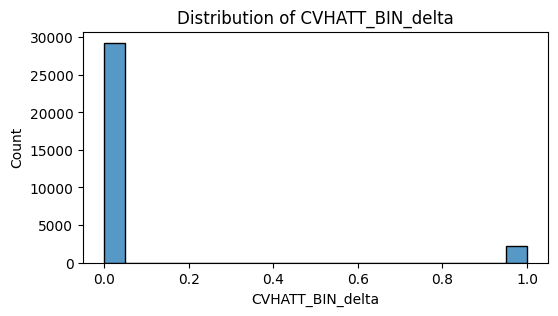

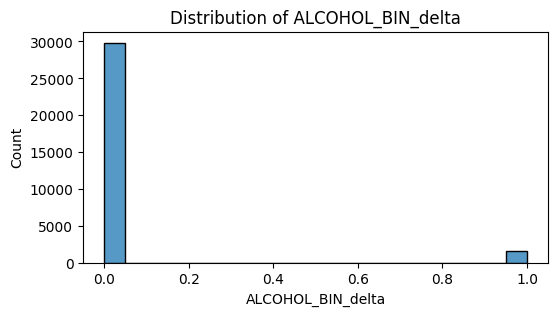

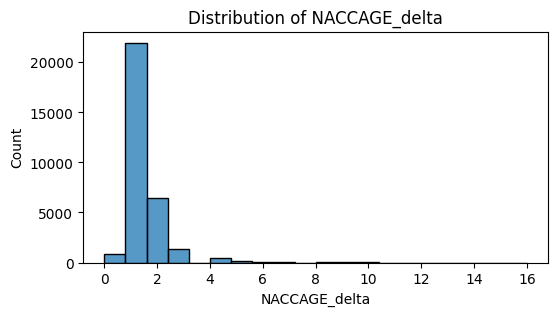

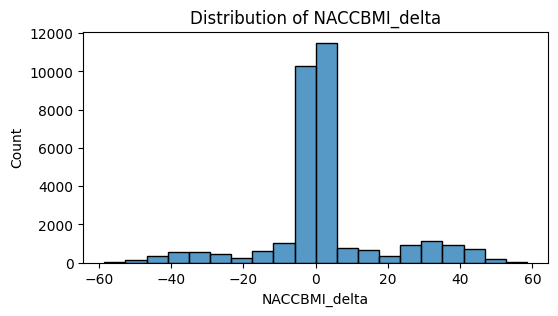

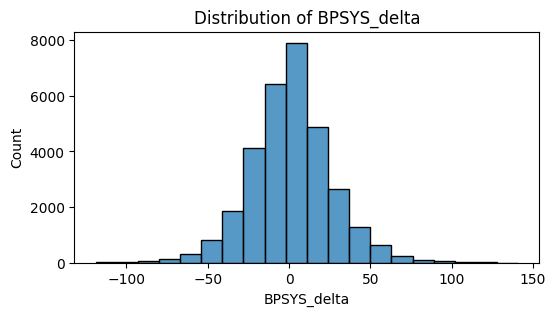

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

delta_features = [
    "STROKE_delta", "TOBAC30_delta",
    "HYPERTEN_BIN_delta", "DIABETES_BIN_delta", "HYPERCHO_BIN_delta",
    "CVHATT_BIN_delta", "ALCOHOL_BIN_delta",
    "NACCAGE_delta", "NACCBMI_delta", "BPSYS_delta"
]

for col in delta_features:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], bins=20, kde=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Include"NACCBMI_delta", "BPSYS_delta","HYPERCHO_BIN_delta","HYPERTEN_BIN_delta" in the model beecause they have balanced distribution

In [4]:
# Because the model is binary classification, we need to convert categorical variables into binary variables.
df['SEX_female'] = (df['SEX_1'] == 2).astype(int)
df['SEX_female'].value_counts()

SEX_female
1    17910
0    13527
Name: count, dtype: int64

In [5]:
# Remove the '_1' suffix from column names ending with '_1'
df = df.rename(columns={col: col[:-2] for col in df.columns if col.endswith('_1')})

In [6]:
# Base Model without cognitive variables
df["target"]=df["NACCALZD"].astype(int)  # Use the NACCALZD column as the target variable

features=["NACCAGE","SEX_female","EDUC","NACCFAM","HYPERCHO_BIN","CVHATT_BIN","ALCOHOL_BIN",
          "DIABETES_BIN","NACCBMI_delta", "BPSYS_delta","HYPERCHO_BIN_delta","HYPERTEN_BIN_delta"]
X=df[features].dropna()
y=df.loc[X.index, "target"]

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=LogisticRegression(max_iter=1000,class_weight=None)
model.fit(x_train,y_train)

y_pred=model.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2695  861]
 [1573 1159]]
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3556
           1       0.57      0.42      0.49      2732

    accuracy                           0.61      6288
   macro avg       0.60      0.59      0.59      6288
weighted avg       0.61      0.61      0.60      6288



Improvement

In [7]:
# Base Model without cognitive variables
df["target"]=df["NACCALZD"].astype(int)  # Use the NACCALZD column as the target variable

features=["NACCAGE","SEX_female","EDUC","NACCFAM","HYPERCHO_BIN","CVHATT_BIN","ALCOHOL_BIN",
          "DIABETES_BIN","HYPERTEN_BIN_delta","HYPERCHO_BIN_delta","NACCBMI_delta", "BPSYS_delta"]
X=df[features].dropna()
y=df.loc[X.index, "target"]

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(x_train,y_train)

y_pred=model.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2127 1429]
 [1079 1653]]
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      3556
           1       0.54      0.61      0.57      2732

    accuracy                           0.60      6288
   macro avg       0.60      0.60      0.60      6288
weighted avg       0.61      0.60      0.60      6288



In [8]:
# History of the family with Alzheimer's disease is a significant risk factor for developing Alzheimer's disease in this model.
# It is interesting that the female have a lower risk of developing Alzheimer's, which is contrary to the common belief. 
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

               Feature  Coefficient
3              NACCFAM     0.250978
6          ALCOHOL_BIN     0.115485
4         HYPERCHO_BIN     0.044492
0              NACCAGE     0.043101
10       NACCBMI_delta     0.010431
11         BPSYS_delta     0.000109
7         DIABETES_BIN    -0.059359
2                 EDUC    -0.073772
5           CVHATT_BIN    -0.073876
8   HYPERTEN_BIN_delta    -0.199248
9   HYPERCHO_BIN_delta    -0.256057
1           SEX_female    -0.325868


In [9]:
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
# Predicting probabilities for the test set (Positive class probabilities)
y_prob = model.predict_proba(x_test)[:, 1]

# Testing different thresholds to see how they affect the predictions
for threshold in [0.5, 0.4, 0.3]:
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\nThreshold = {threshold}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))


Threshold = 0.5
[[2127 1429]
 [1079 1653]]
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      3556
           1       0.54      0.61      0.57      2732

    accuracy                           0.60      6288
   macro avg       0.60      0.60      0.60      6288
weighted avg       0.61      0.60      0.60      6288

AUC: 0.6367208537073422

Threshold = 0.4
[[1101 2455]
 [ 468 2264]]
              precision    recall  f1-score   support

           0       0.70      0.31      0.43      3556
           1       0.48      0.83      0.61      2732

    accuracy                           0.54      6288
   macro avg       0.59      0.57      0.52      6288
weighted avg       0.61      0.54      0.51      6288

AUC: 0.6367208537073422

Threshold = 0.3
[[ 383 3173]
 [ 117 2615]]
              precision    recall  f1-score   support

           0       0.77      0.11      0.19      3556
           1       0.45      0.96      0.61      2732

  

In [10]:
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

features = ["NACCAGE","SEX_female","EDUC","NACCFAM","HYPERCHO_BIN","CVHATT_BIN","ALCOHOL_BIN",
          "DIABETES_BIN","HYPERTEN_BIN_delta","HYPERCHO_BIN_delta","NACCBMI_delta", "BPSYS_delta"]

X = df[features].fillna(0)  
y = df["NACCALZD"].astype(int)  

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weight (Handling class imbalance)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Model definition
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (class_weight is used to handle class imbalance)
model.fit(x_train, y_train, epochs=20, batch_size=32, class_weight=class_weights_dict, validation_split=0.2)

# Predict on the test set
# Print confusion matrix and classification report
y_pred_prob = model.predict(x_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Epoch 1/20


629/629 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5074 - loss: 1.6015 - val_accuracy: 0.5646 - val_loss: 0.6893
Epoch 2/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5315 - loss: 0.6974 - val_accuracy: 0.4419 - val_loss: 0.6993
Epoch 3/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5205 - loss: 0.6940 - val_accuracy: 0.4817 - val_loss: 0.6915
Epoch 4/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5255 - loss: 0.6911 - val_accuracy: 0.5942 - val_loss: 0.6858
Epoch 5/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5444 - loss: 0.6910 - val_accuracy: 0.5911 - val_loss: 0.6771
Epoch 6/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5717 - loss: 0.6819 - val_accuracy: 0.5841 - val_loss: 0.6780
Epoch 7/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5844 - loss: 0.6779 - val_accuracy: 0.5915 - val_loss: 0.6731
Epoch 8/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5915 - loss: 0.6744 - val_accuracy: 0.6016 - val_

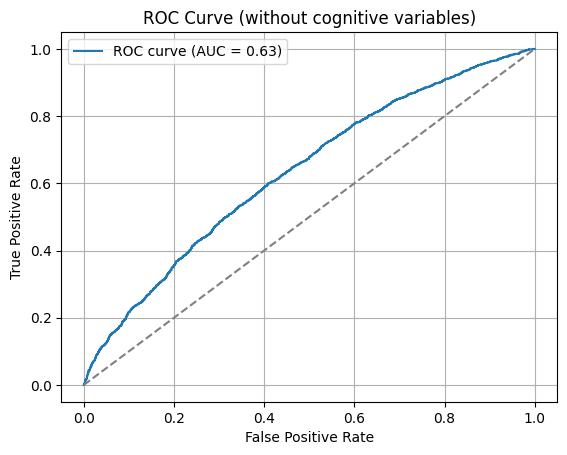

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (without cognitive variables)')
plt.legend()
plt.grid(True)
plt.show()

# Model that only has change value without base value

In [12]:
# Base Model without cognitive variables
df["target"]=df["NACCALZD"].astype(int)  # Use the NACCALZD column as the target variable
features=["SEX_female","EDUC","NACCFAM",
          "STROKE_delta","TOBAC30_delta",
          "HYPERTEN_BIN_delta", "DIABETES_BIN_delta",  "HYPERCHO_BIN_delta" , "CVHATT_BIN_delta",   
            "ALCOHOL_BIN_delta", "NACCAGE_delta", "NACCBMI_delta", "BPSYS_delta" ]
X=df[features].dropna()
y=df.loc[X.index, "target"]

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=LogisticRegression(max_iter=1000,class_weight=None)
model.fit(x_train,y_train)

y_pred=model.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2868  688]
 [1943  789]]
              precision    recall  f1-score   support

           0       0.60      0.81      0.69      3556
           1       0.53      0.29      0.37      2732

    accuracy                           0.58      6288
   macro avg       0.57      0.55      0.53      6288
weighted avg       0.57      0.58      0.55      6288



# Model with Cognitive Variable

In [13]:
# Base Model without cognitive variables
df["target"]=df["NACCALZD"].astype(int)  # Use the NACCALZD column as the target variable
features=["NACCAGE","SEX_female","EDUC","STROKE","TOBAC30","NACCFAM","HYPERTEN_BIN","DIABETES_BIN",
          "HYPERCHO_BIN","CVHATT_BIN","ALCOHOL_BIN","STROKE_delta","TOBAC30_delta","NACCFAM_delta",
          "HYPERTEN_BIN_delta",  "HYPERCHO_BIN_delta","NACCBMI_delta", "BPSYS_delta", "COGMODE_delta",
          "DEPD_delta", "MEMORY_delta", "ORIENT_delta","ORIENT", "COGMODE", "DEPD", "MEMORY"]

X=df[features].dropna()
y=df.loc[X.index, "target"]

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=LogisticRegression(max_iter=1000,class_weight=None)
model.fit(x_train,y_train)

y_pred=model.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2882  674]
 [ 360 2372]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3556
           1       0.78      0.87      0.82      2732

    accuracy                           0.84      6288
   macro avg       0.83      0.84      0.83      6288
weighted avg       0.84      0.84      0.84      6288



In [14]:
# Base Model with cognitive variables
df["target"]=df["NACCALZD"].astype(int)  # Use the NACCALZD column as the target variable
features=["NACCAGE","SEX_female","EDUC","STROKE","TOBAC30","NACCFAM","HYPERTEN_BIN","DIABETES_BIN",
          "HYPERCHO_BIN","CVHATT_BIN","ALCOHOL_BIN","STROKE_delta","TOBAC30_delta","NACCFAM_delta",
          "HYPERTEN_BIN_delta",  "HYPERCHO_BIN_delta","NACCBMI_delta", "BPSYS_delta", "COGMODE_delta",
          "DEPD_delta", "MEMORY_delta", "ORIENT_delta","ORIENT", "COGMODE", "DEPD", "MEMORY"]

X=df[features].dropna()
y=df.loc[X.index, "target"]

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=LogisticRegression(max_iter=1000,class_weight="balanced")
model.fit(x_train,y_train)

y_pred=model.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


[[2748  808]
 [ 223 2509]]
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      3556
           1       0.76      0.92      0.83      2732

    accuracy                           0.84      6288
   macro avg       0.84      0.85      0.84      6288
weighted avg       0.85      0.84      0.84      6288



In [15]:
from sklearn.metrics import precision_score, recall_score,roc_auc_score

y_prob = model.predict_proba(x_test)[:, 1]

for threshold in [0.5, 0.4, 0.3]:
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\n[Threshold = {threshold}]")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Recall (Sensitivity):", recall_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))


[Threshold = 0.5]
[[2748  808]
 [ 223 2509]]
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      3556
           1       0.76      0.92      0.83      2732

    accuracy                           0.84      6288
   macro avg       0.84      0.85      0.84      6288
weighted avg       0.85      0.84      0.84      6288

Recall (Sensitivity): 0.9183748169838946
Precision: 0.7564063913174556
AUC: 0.9066782556280025

[Threshold = 0.4]
[[2611  945]
 [  98 2634]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      3556
           1       0.74      0.96      0.83      2732

    accuracy                           0.83      6288
   macro avg       0.85      0.85      0.83      6288
weighted avg       0.86      0.83      0.83      6288

Recall (Sensitivity): 0.9641288433382138
Precision: 0.7359597652975691
AUC: 0.9066782556280025

[Threshold = 0.3]
[[2517 1039]
 [  59 2673]]
              prec

In [16]:
#History of the family with Alzheimer's disease is a significant risk factor for developing Alzheimer's disease in this model.
#It is interesting that the female have a lower risk of developing Alzheimer's, which is contrary to the common belief. Need to check the data again.
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

               Feature  Coefficient
23             COGMODE     3.120995
25              MEMORY     1.122398
5              NACCFAM     0.367451
1           SEX_female     0.226729
4              TOBAC30     0.124001
8         HYPERCHO_BIN     0.065603
0              NACCAGE     0.052919
7         DIABETES_BIN     0.050072
19          DEPD_delta     0.036261
21        ORIENT_delta     0.010726
6         HYPERTEN_BIN     0.010345
13       NACCFAM_delta     0.000000
17         BPSYS_delta    -0.000294
16       NACCBMI_delta    -0.000515
24                DEPD    -0.003869
22              ORIENT    -0.010286
2                 EDUC    -0.014194
9           CVHATT_BIN    -0.059160
10         ALCOHOL_BIN    -0.092752
12       TOBAC30_delta    -0.105059
15  HYPERCHO_BIN_delta    -0.105547
14  HYPERTEN_BIN_delta    -0.109917
11        STROKE_delta    -0.157818
3               STROKE    -0.235160
20        MEMORY_delta    -0.328993
18       COGMODE_delta    -0.659563


In [17]:
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Feature, target 준비
features =["NACCAGE","SEX_female","EDUC","STROKE","TOBAC30","NACCFAM","HYPERTEN_BIN","DIABETES_BIN",
          "HYPERCHO_BIN","CVHATT_BIN","ALCOHOL_BIN","STROKE_delta","TOBAC30_delta","NACCFAM_delta",
          "HYPERTEN_BIN_delta",  "HYPERCHO_BIN_delta","NACCBMI_delta", "BPSYS_delta", "COGMODE_delta",
          "DEPD_delta", "MEMORY_delta", "ORIENT_delta","ORIENT", "COGMODE", "DEPD", "MEMORY"]
df["target"] = df["NACCALZD"].astype(int)  # Use the NACCALZD column as the target variable

X = df[features].fillna(0) 
y = df["target"]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Class weight calculation (response to class imbalance)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Model definition
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model training (class_weight is used to handle class imbalance)
model.fit(x_train, y_train, epochs=20, batch_size=32, class_weight=class_weights_dict, validation_split=0.2)

# Predict on the test set
# Print confusion matrix and classification report
y_pred_prob = model.predict(x_test).flatten()
y_pred = (y_pred_prob >= 0.4).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Epoch 1/20


629/629 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5491 - loss: 1.5930 - val_accuracy: 0.7588 - val_loss: 0.5897
Epoch 2/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7232 - loss: 0.5700 - val_accuracy: 0.8249 - val_loss: 0.4135
Epoch 3/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8129 - loss: 0.4292 - val_accuracy: 0.8177 - val_loss: 0.3938
Epoch 4/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8194 - loss: 0.3960 - val_accuracy: 0.8197 - val_loss: 0.3737
Epoch 5/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8296 - loss: 0.3755 - val_accuracy: 0.8250 - val_loss: 0.3657
Epoch 6/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8284 - loss: 0.3626 - val_accuracy: 0.8209 - val_loss: 0.3663
Epoch 7/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8317 - loss: 0.3652 - val_accuracy: 0.8272 - val_loss: 0.3641
Epoch 8/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8288 - loss: 0.3598 - val_accuracy: 0.8211 - val_

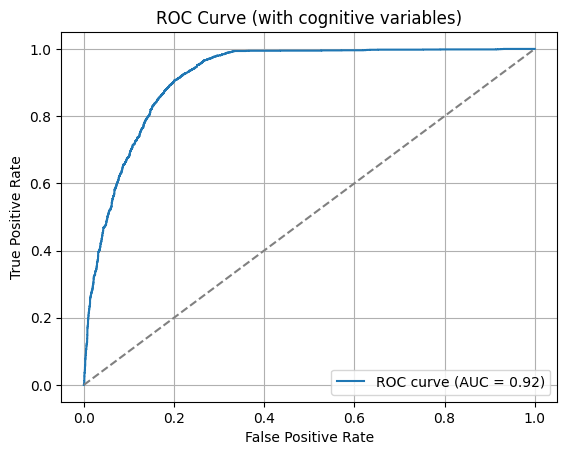

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (with cognitive variables)')
plt.legend()
plt.grid(True)
plt.show()
